In [8]:
import pandas as pd
import json
pd.options.display.max_columns=100
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

### Data validation

In [9]:
df = pd.read_excel("data/parsedValdiationResults.xlsx")

In [10]:
validation=df[["Name",'HMFID','Validation parsed 4 digit types','Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']].rename(columns={'Validation parsed 4 digit types':"A1",'Unnamed: 21':"A2", 'Unnamed: 22':"B1", 'Unnamed: 23':"B2", 'Unnamed: 24':"C1", 'Unnamed: 25':"C2"}).set_index(["HMFID","Name"])
validation.head()

,,A1,A2,B1,B2,C1,C2
HMFID,Name,,,,,,
CPCT02070444R,S5586-HMF-VAL-HLA-BLOOD-01,A*23:01,A*32:01,B*44:02,B*44:03,C*04:01,C*05:01
CPCT02070446R,S5587-HMF-VAL-HLA-BLOOD-02,A*24:02,A*26:01,B*15:02,B*15:06,C*04:03,C*08:01
CPCT02060289R,S5588-HMF-VAL-HLA-BLOOD-03,A*02:01,A*33:01,B*14:02,B*44:02,C*05:01,C*08:02
CPCT02070485R,S5589-HMF-VAL-HLA-BLOOD-04,A*30:02,A*68:02,B*44:02,B*53:01,C*04:01,C*07:02
CPCT02080312R,S5590-HMF-VAL-HLA-BLOOD-05,A*03:01,A*25:01,B*15:01,B*35:03,C*03:04,C*04:01


### Find data in case of missing

In [11]:
def transform_allele_poly(r):
    r=r.upper().replace("HLA_","")
    return r[0]+"*"+r[2:4]+":"+r[5:7]
    
def read_polysolver(path):
    l=[]
    if not(os.path.exists(path)):
        return []
    with open(path,'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            _,hla_1,hla_2 = line.split("\t")
            p_hla_1,p_hla_2 = transform_allele_poly(hla_1),transform_allele_poly(hla_2)
            l+=[p_hla_1,p_hla_2]
            
    return l
def read_hlas_xhla(path):
    if not(os.path.exists(path)):
        return []
    with open(path, 'r') as f:
        d = json.load(f)["hla"]
    list_normal_total = [get_4digit_xhla(hla) for hla in d["alleles"]]
    list_normal_I = list([hla for hla in list_normal_total if hla[4] != "D"]) # only class I at this moment
    list_normal_parsed = [hla[4]+"*"+hla[5:] for hla in list_normal_I]
    return list_normal_parsed

def get_4digit_xhla(hla):
    v = "HLA-" + hla.replace("*", "")
    if v[-1] == "N": # this allele is raising an error...
        return v[0:-1] # remove the "N" of the final...
    return v            
def find_sample(donor):
    
    filein1=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac_validation/{donor}/{donor}_normal.lilac.csv.gz"
    filein2=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac_validation/{donor}/{donor}_tumor.lilac.csv.gz"
    if not(os.path.exists(filein1)):
        if len(donor) < 16:
            return find_sample(donor+"I")
        else:
            return {}
    df=pd.read_csv(filein1,sep=",")
    df1=pd.read_csv(filein2,sep=",")
    alleles_normal_lilac = df["Allele"].values
    alleles_tumor_lilac = df1["Allele"].values
    
    # find polysolver
    path_normal_polysolver=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_normal/winners.hla.txt"
    path_tumor_polysolver=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_tumor/winners.hla.txt"
    alleles_normal_poly = read_polysolver(path_normal_polysolver)
    alleles_tumor_poly = read_polysolver(path_tumor_polysolver)
    # find xhla
    path_normal_xhla=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_normal_xhla/report-{donor}-hla.json"
    path_tumor_xhla=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_tumor_xhla/report-{donor}-hla.json"
    alleles_normal_xhla = read_hlas_xhla(path_normal_xhla)
    alleles_tumor_xhla = read_hlas_xhla(path_tumor_xhla)
    # general
    return {"polysolver":{"normal":alleles_normal_poly,"tumor":alleles_tumor_poly},"xHLA":{"normal":alleles_normal_xhla,"tumor":alleles_tumor_xhla},"LILAC":{"normal":alleles_normal_lilac,"tumor":alleles_tumor_lilac}}

### Find information for all samples

In [37]:
with open("data/per_sample_HLA_type.json") as f:
    d_data = json.load(f)
for t,r in validation.iterrows(): # first tests whether all samples are included
    i=t[0]
    sample = i.replace("R","T")
    if not(sample in d_data):
        d_data[sample] = find_sample(sample)

In [38]:
l=[]
for t,r in validation.iterrows():
    i=t[0]
    sample = i.replace("R","T")
    
    data_lilac=d_data[sample]["LILAC"]["normal"]
    data_xhla=d_data[sample]["xHLA"]["normal"]
    data_polysolver=d_data[sample]["polysolver"]["normal"]
    for e in ["A1","A2","B1","B2","C1","C2"]:
        allele=r[e]
        if "XX" in allele or "Rejected" in allele or len(allele) <7: # was not defined experimentally
            l.append([t[1],sample,i,sample==i,allele,False,np.nan,np.nan,np.nan])
            continue
        l.append([t[1],sample,i,sample==i,allele,True,allele in data_lilac,allele in data_xhla,allele in data_polysolver])
df_val = pd.DataFrame(l,columns=["id_s","sample","sample_original","tumor_sample","allele","exp_valid","lilac","xhla","polysolver"])               

In [32]:
df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")[["sample_id","sample_id_2"]].rename(columns={"sample_id":"sample","sample_id_2":"sample_id"})
df_val.merge(df_meta).drop(["sample_original","sample"],axis=1).to_csv("data/gendx_validation_info.tsv",sep="\t",index=False)

### Plot it!

In [34]:
colors = {"polysolver":"#e41a1c","xhla":"#377eb8","LILAC":"#4daf4a"}

### Number of samples

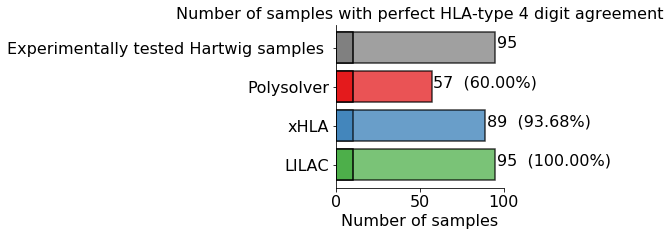

In [50]:
total_samples = len(df_val[df_val["exp_valid"]]["sample_original"].unique())
total_samples_tumor = len(df_val[df_val["tumor_sample"]==True]["sample_original"].unique())
# general 
samples_with_hla_typing_polysolver = total_samples - len(df_val[(df_val["exp_valid"])&(df_val["polysolver"]==False)]["sample"].unique())
samples_with_hla_typing_polysolver_tumor = total_samples_tumor - len(df_val[(df_val["exp_valid"])&(df_val["polysolver"]==False)&(df_val["tumor_sample"])]["sample"].unique())
samples_with_hla_typing_xhla = total_samples - len(df_val[(df_val["exp_valid"])&(df_val["xhla"]==False)]["sample"].unique())
samples_with_hla_typing_xhla_tumor = total_samples_tumor - len(df_val[(df_val["exp_valid"])&(df_val["xhla"]==False)&(df_val["tumor_sample"])]["sample"].unique())
samples_with_hla_typing_LILAC = total_samples - len(df_val[(df_val["exp_valid"])&(df_val["lilac"]==False)]["sample"].unique())
samples_with_hla_typing_LILAC_tumor = total_samples_tumor - len(df_val[(df_val["exp_valid"])&(df_val["lilac"]==False)&(df_val["tumor_sample"])]["sample"].unique())

fig,ax = plt.subplots(figsize=(3,3))
colors = {"polysolver":"#e41a1c","xhla":"#377eb8","LILAC":"#4daf4a"}
yticks_labels = ["Experimentally tested Hartwig samples "]
yticks = []
y=0
ax.barh(y=y,width=total_samples,color="grey",edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_polysolver_tumor,color="grey",edgecolor="black",linewidth=1.5,alpha=1.0)

ax.annotate(xy=(total_samples+1,y),s=str(total_samples),fontsize=16 )
yticks.append(y)
y-=1
yticks_labels.append("Polysolver")
ax.barh(y=y,width=samples_with_hla_typing_polysolver,color=colors["polysolver"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_polysolver_tumor,color=colors["polysolver"],edgecolor="black",linewidth=1.5,alpha=1.0)
ax.annotate(xy=(samples_with_hla_typing_polysolver+1,y),s=str(samples_with_hla_typing_polysolver) + "  ({0:.2%})".format(samples_with_hla_typing_polysolver/total_samples),fontsize=16)
yticks_labels.append("xHLA")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_xhla,color=colors["xhla"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_xhla_tumor,color=colors["xhla"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.annotate(xy=(samples_with_hla_typing_xhla+1,y),s=str(samples_with_hla_typing_xhla) + "  ({0:.2%})".format(samples_with_hla_typing_xhla/total_samples),fontsize=16)
yticks_labels.append("LILAC")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_LILAC,color=colors["LILAC"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_LILAC_tumor,color=colors["LILAC"],edgecolor="black",linewidth=1.5,alpha=1.)
ax.annotate(xy=(samples_with_hla_typing_LILAC+1,y),s=str(samples_with_hla_typing_LILAC) + "  ({0:.2%})".format(samples_with_hla_typing_LILAC/total_samples),fontsize=16)
yticks.append(y)

ax.set_xlim(0,100)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of samples",fontsize=16)
ax.set_title("Number of samples with perfect HLA-type 4 digit agreement",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(f'../results/figures/figure1/exp_validation_patients.pdf', dpi=800,bbox_inches="tight")

### By allele

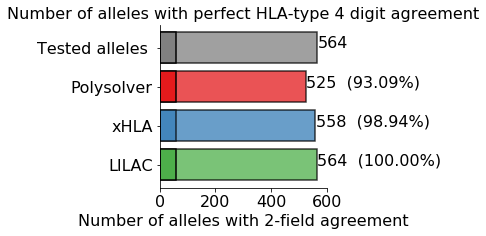

In [49]:
total_samples = df_val[df_val["exp_valid"]]["allele"].shape[0]
total_samples_tumor = df_val[df_val["tumor_sample"]==True].shape[0]
# general 
samples_with_hla_typing_polysolver = total_samples - df_val[(df_val["exp_valid"])&(df_val["polysolver"]==False)].shape[0]
samples_with_hla_typing_polysolver_tumor = total_samples_tumor - df_val[(df_val["exp_valid"])&(df_val["polysolver"]==False)&(df_val["tumor_sample"])].shape[0]
samples_with_hla_typing_xhla = total_samples - df_val[(df_val["exp_valid"])&(df_val["xhla"]==False)].shape[0]
samples_with_hla_typing_xhla_tumor = total_samples_tumor - df_val[(df_val["exp_valid"])&(df_val["xhla"]==False)&(df_val["tumor_sample"])].shape[0]
samples_with_hla_typing_LILAC = total_samples - df_val[(df_val["exp_valid"])&(df_val["lilac"]==False)].shape[0]
samples_with_hla_typing_LILAC_tumor = total_samples_tumor - df_val[(df_val["exp_valid"])&(df_val["lilac"]==False)&(df_val["tumor_sample"])].shape[0]

fig,ax = plt.subplots(figsize=(3,3))
colors = {"polysolver":"#e41a1c","xhla":"#377eb8","LILAC":"#4daf4a"}
yticks_labels = ["Tested alleles "]
yticks = []
y=0
ax.barh(y=y,width=total_samples,color="grey",edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_polysolver_tumor,color="grey",edgecolor="black",linewidth=1.5,alpha=1.0)

ax.annotate(xy=(total_samples+1,y),s=str(total_samples),fontsize=16 )
yticks.append(y)
y-=1
yticks_labels.append("Polysolver")
ax.barh(y=y,width=samples_with_hla_typing_polysolver,color=colors["polysolver"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_polysolver_tumor,color=colors["polysolver"],edgecolor="black",linewidth=1.5,alpha=1.0)
ax.annotate(xy=(samples_with_hla_typing_polysolver+1,y),s=str(samples_with_hla_typing_polysolver) + "  ({0:.2%})".format(samples_with_hla_typing_polysolver/total_samples),fontsize=16)
yticks_labels.append("xHLA")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_xhla,color=colors["xhla"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_xhla_tumor,color=colors["xhla"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.annotate(xy=(samples_with_hla_typing_xhla+1,y),s=str(samples_with_hla_typing_xhla) + "  ({0:.2%})".format(samples_with_hla_typing_xhla/total_samples),fontsize=16)
yticks_labels.append("LILAC")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_LILAC,color=colors["LILAC"],edgecolor="black",linewidth=1.5,alpha=0.75)
ax.barh(y=y,width=samples_with_hla_typing_LILAC_tumor,color=colors["LILAC"],edgecolor="black",linewidth=1.5,alpha=1.)
ax.annotate(xy=(samples_with_hla_typing_LILAC+1,y),s=str(samples_with_hla_typing_LILAC) + "  ({0:.2%})".format(samples_with_hla_typing_LILAC/total_samples),fontsize=16)
yticks.append(y)

ax.set_xlim(0,600)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of alleles with 2-field agreement",fontsize=16)
ax.set_title("Number of alleles with perfect HLA-type 4 digit agreement",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(f'../results/figures/figure1/exp_validation_alleles.pdf', dpi=800,bbox_inches="tight")

### 